<a href="https://colab.research.google.com/github/sandeepkumar9343/Pneumonia-Diagnosis/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PNEUMONIA  Detection using CNN.**

What is Pneumonia?

 Pneumonia is an infection that inflames the air sacs in one or both lungs.The air sacs may fill with the fluid or pus(purulent material), causing cough with phlegm or pus,fever,chills nad difficulty breathing.A variety of organisms including bacteria,virus and fungi can cause pneumonia.

Pneumonia can range in seriousness from mild to life threatening.it is most serious for infant and young children,people older than 65,and people with health problems or weakened immune systems.

**Pneumonia Detection with Convolutional Neural Networks**

Computer Vision can be realized using Convolutional neural networks (CNN) They are neural networks making features extraction over an image before classifying it. The feature extraction performed consists of three basic operations:


1.Filter an image for a particular feature (convolution).

2.Detect that feature within the filtered image (using the ReLU activation)

3.Condense the image to enhance the features (maximum pooling).



In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle 

In [3]:

!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#DOWNLOADING THE PNEUMONIA DATASET FROM KAGGLE DIRECTLY.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:30<00:01, 14.2MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.7MB/s]


In [6]:
#moving downloaded datato new folder 'tomatodisease'.
!mkdir pneumonia
!mv chest-xray-pneumonia.zip pneumonia

In [7]:
%cd pneumonia/  

/content/pneumonia


In [8]:
#downloaded data is in zip format.so,we need to unzip the file.
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [9]:

# Import modules and packages
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.metrics import categorical_crossentropy
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix

import glob
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [10]:
print('Tensorflow version = {}'.format(tf.__version__))
print('Keras version = {}'.format(keras.__version__))

Tensorflow version = 2.4.0
Keras version = 2.4.3


In [11]:
#Setting the image size as 150,150.
IMAGE_SIZE=[150,150]

In [12]:
train_path ='/content/pneumonia/chest_xray/train'
valid_path ='/content/pneumonia/chest_xray/val'
test_path ='/content/pneumonia/chest_xray/test'

In [15]:
from glob import glob
#checking no of folders in train data.Each folders is of diff class.
folders=glob('/content/pneumonia/chest_xray/train/*')

In [16]:
folders

['/content/pneumonia/chest_xray/train/NORMAL',
 '/content/pneumonia/chest_xray/train/PNEUMONIA']

Text(0.5, 1.0, 'Normal')

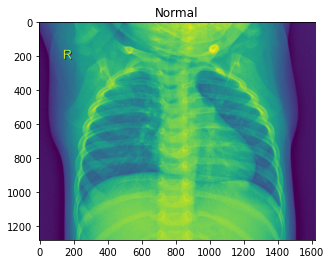

In [17]:
#visualizing sample image from 'NORMAL' class.
plt.imshow(plt.imread('/content/pneumonia/chest_xray/train/NORMAL/IM-0122-0001.jpeg'))
plt.title('Normal')

Text(0.5, 1.0, 'PNEUMONIA')

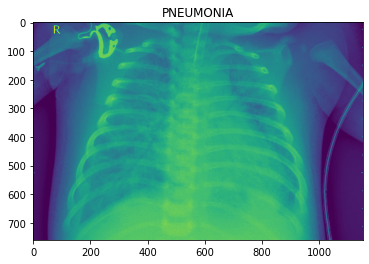

In [18]:
#visualizing sample image from 'PNEUMONIA' class.
plt.imshow(plt.imread('/content/pneumonia/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'))
plt.title('PNEUMONIA')

In [20]:
#Data Augmentation
# Used ImageDataGenerator used to generate more images from existing images and then train the model on the same.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True
                                 )

valid_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen=ImageDataGenerator(rescale=1./255)

In [21]:
training_set=train_datagen.flow_from_directory('/content/pneumonia/chest_xray/train',
                                               target_size=(150,150),
                                               batch_size=16,
                                               class_mode='categorical')

Found 5216 images belonging to 2 classes.


In [22]:
validation_set=valid_datagen.flow_from_directory('/content/pneumonia/chest_xray/val',
                                               target_size=(150,150),
                                               batch_size=16,
                                               class_mode='categorical')

Found 16 images belonging to 2 classes.


In [25]:
test_set=test_datagen.flow_from_directory('/content/pneumonia/chest_xray/test',
                                          target_size=(150,150),
                                          batch_size=16,
                                          class_mode='categorical'
                                          )

Found 624 images belonging to 2 classes.


**Building CNN Model**

In [33]:

model = Sequential()
model.add(Convolution2D(64, (5, 5), input_shape = (150, 150, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))

model.add(Convolution2D(128, (4, 4), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))

model.add(Convolution2D(512, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))

model.add(Convolution2D(512, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(activation = 'relu', units=512))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))

model.add(Dense(activation = 'relu', units=256))
model.add(BatchNormalization(axis = -1))
model.add(Dropout(0.2))

model.add(Dense(activation = 'sigmoid', units=2))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 146, 146, 64)      4864      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 70, 70, 128)       131200    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 35, 35, 128)      

In [45]:
%%time
history =model.fit(training_set,
                   validation_data=test_set,
                   epochs=25,
                   steps_per_epoch=len(training_set),
                   validation_steps=len(test_set),
                   verbose=2)

Epoch 1/25
326/326 - 73s - loss: 0.1951 - accuracy: 0.9281 - val_loss: 2.0316 - val_accuracy: 0.6250
Epoch 2/25
326/326 - 72s - loss: 0.2023 - accuracy: 0.9225 - val_loss: 0.3436 - val_accuracy: 0.8782
Epoch 3/25
326/326 - 73s - loss: 0.1690 - accuracy: 0.9371 - val_loss: 0.8707 - val_accuracy: 0.7067
Epoch 4/25
326/326 - 73s - loss: 0.1759 - accuracy: 0.9363 - val_loss: 1.2006 - val_accuracy: 0.7067
Epoch 5/25
326/326 - 73s - loss: 0.1625 - accuracy: 0.9413 - val_loss: 1.0515 - val_accuracy: 0.6843
Epoch 6/25
326/326 - 73s - loss: 0.1807 - accuracy: 0.9340 - val_loss: 0.6434 - val_accuracy: 0.8510
Epoch 7/25
326/326 - 73s - loss: 0.1621 - accuracy: 0.9415 - val_loss: 0.3198 - val_accuracy: 0.8974
Epoch 8/25
326/326 - 72s - loss: 0.1669 - accuracy: 0.9369 - val_loss: 0.3084 - val_accuracy: 0.8862
Epoch 9/25
326/326 - 73s - loss: 0.1590 - accuracy: 0.9392 - val_loss: 0.7137 - val_accuracy: 0.7612
Epoch 10/25
326/326 - 73s - loss: 0.1439 - accuracy: 0.9471 - val_loss: 0.5427 - val_accura

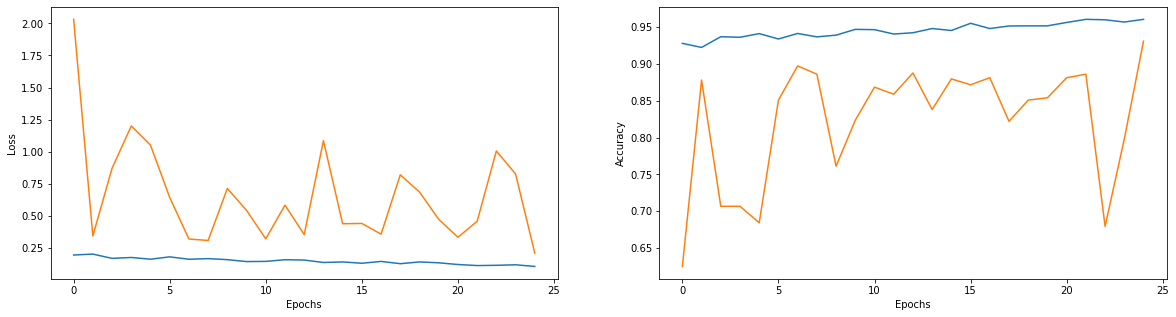

In [46]:
#Plotiing the Loss and Accuracy of our Model.
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss)
plt.plot(val_loss)

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc)
plt.plot(val_acc)

In [47]:
#saving our trained model as 'model_inception.h5'.
from tensorflow.keras.models import load_model
model.save('pneumonia_cnn.h5')

In [49]:
#Evaluating the model in test data.
evaluation = model.evaluate(test_set)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(training_set)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

39/39 [==============================] - 5s 134ms/step - loss: 0.2096 - accuracy: 0.9311
Test Accuracy: 93.11%
326/326 [==============================] - 69s 211ms/step - loss: 0.0977 - accuracy: 0.9632
Train Accuracy: 96.32%


In [50]:
#Evaluating the model on validation dataset.
evaluation = model.evaluate(validation_set)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(training_set)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1/1 [==============================] - 0s 239ms/step - loss: 0.3849 - accuracy: 0.9375
Test Accuracy: 93.75%
326/326 [==============================] - 69s 211ms/step - loss: 0.1012 - accuracy: 0.9618
Train Accuracy: 96.18%


In [54]:
pred = model.predict(test_set)

In [55]:
#considering highest predicted probability values from the diff classes.
y_pred = np.argmax(pred, axis=1)

In [56]:
y_pred

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,

In [57]:
#importing the libraries for loading the saved model.
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [58]:
#reading a sample image from test data 
test_img=image.load_img('/content/pneumonia/chest_xray/test/NORMAL/IM-0021-0001.jpeg',target_size=(150,150))  

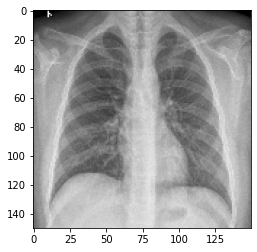

In [59]:
#visualising the sample image.
plt.imshow(test_img)

In [60]:
#converting the img to array for prediction.
x=image.img_to_array(test_img)

In [61]:
x

array([[[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  1.,   1.,   1.],
        [  1.,   1.,   1.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       ...,

       [[111., 111., 111.],
        [115., 115., 115.],
        [118., 118., 118.],
        ...,
        [132., 132., 132.],
        [123., 123., 123.],
        [118., 118., 118.]],

       [[106., 106., 106.],
        [110., 110., 110.],
        [120., 120., 120.],
        ...,
        [126., 126., 126.],
        [123., 123., 123.],
        [105., 105., 105.]],

       [[101., 101., 101.],
        [109., 109., 109.],
        [111., 1

In [62]:
x.shape

(150, 150, 3)

In [63]:
#scaling and preprocessing  the image
x=x/225
x=np.expand_dims(x,axis=0)
x=x.reshape(1,150,150,3)
print(x.shape)

(1, 150, 150, 3)


In [64]:
#prediction on sample image.
model.predict(x)

array([[0.9011476 , 0.34353063]], dtype=float32)

In [65]:
a=np.argmax(model.predict(x),axis=1)

In [66]:
#its predicting the image as NORMAL.
a

array([0])

In [67]:
#loading the saved model
import tensorflow as tf
model_cnn=tf.keras.models.load_model('pneumonia_cnn.h5')

In [68]:
#there are 10 different classes in the data.
class_dict = training_set.class_indices
class_dict

{'NORMAL': 0, 'PNEUMONIA': 1}

In [96]:
#Defining a function which automatically read the image, standardize the image and perform prediction. 
def predict(filepath):
  img=image.load_img(filepath,target_size=(150,150))  #reading the image
  img=image.img_to_array(img)
  img=img/255
  x=np.expand_dims(img,axis=0)
  x=x.reshape(1,150,150,3)
  preds=model_cnn.predict_classes(x)   #predicting the image.


    #Below condition statements returns the class associated with the images.
  if preds ==0:
    print('We think that is NORMAL')
  else:
    print('We think PNEUMONIA')  
  

In [97]:
#It correctly predicts the normal image as normal.
predict('/content/pneumonia/chest_xray/test/NORMAL/IM-0021-0001.jpeg')

We think that is NORMAL


In [98]:
#It correctly predicts the normal image as normal.
predict('/content/pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg')

We think that is NORMAL


In [99]:
#It correctly predicts the PNEUMONIA image as PNEUMONIA.
predict('/content/pneumonia/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg')

We think PNEUMONIA


In [100]:
#It correctly predicts the PNEUMONIA image as PNEUMONIA.
predict('/content/pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg')

We think PNEUMONIA


In [101]:
#It correctly predicts the normal image as normal.
predict('/content/pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0079-0001.jpeg')

We think that is NORMAL


In [102]:
#It correctly predicts the PNEUMONIA image as PNEUMONIA.
predict('/content/pneumonia/chest_xray/test/PNEUMONIA/person138_bacteria_659.jpeg')

We think PNEUMONIA
